#Import libraries


In [1]:
import pandas as pd
import numpy as np
import spacy
import random

!pip install -U gensim

from gensim import models
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.test.utils import datapath

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import gridspec
%matplotlib inline

!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

     |████████████████████████████████| 24.1 MB 57.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 4.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=90f2376718e7ff1b14577a52b808c9a8525b26eb4aa493f8800dad0f16f7e723
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


#Load data




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
random.seed(10)
no_dups = pd.read_csv("/content/drive/MyDrive/TFM/preprocessed_lda_wodups.csv", 
                      index_col=0)
print(no_dups.shape)
no_dups.head()

(976, 3)


,Text,Label,Tokens
0,"""https://paperswithcode.com/method/gan-tts GAN...",Sequential,"['gan', 'tts', 'gan', 'tts', 'gan', 'tts', 'ge..."
1,"""https://paperswithcode.com/method/bert BERT B...",Natural Language Processing,"['bert', 'bert', 'bert', 'bidirect', 'encod', ..."
2,"""https://paperswithcode.com/method/fasttext fa...",Natural Language Processing,"['fasttext', 'fasttext', 'fasttext', 'embed', ..."
3,"""https://paperswithcode.com/method/faster-r-cn...",Computer Vision,"['faster', 'cnn', 'faster', 'cnn', 'faster', '..."
4,"""https://paperswithcode.com/method/rpn RPN Reg...",Computer Vision,"['rpn', 'region', 'propos', 'network', 'region..."


#Create corpus

In [4]:
no_dups.Tokens = no_dups.Tokens.apply(eval)

In [5]:
diccionario = Dictionary(no_dups.Tokens)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 3845


Finally, we remove the words that are in less than two abstracts and in more than 80% of them since these will introduce more noise than information into our model. Once these words have been filtered we create the final bag of words.

In [6]:
#Words that are at least in two abstracts and in no more than 80% of abstracts
diccionario.filter_extremes(no_below=2, no_above = 0.8)
print(f'Number de tokens: {len(diccionario)}')

Number de tokens: 2171


In [7]:
#Doc to bag of words (here we dont take into account bigrams or trigrams)
corpus = [diccionario.doc2bow(abstract) for abstract in no_dups.Tokens]
print(corpus[20])
print(diccionario[17])
#Word with key 9 appears once, word with key 17 appears 6 times , etc

[(4, 1), (6, 1), (13, 3), (35, 2), (58, 1), (71, 1), (103, 1), (121, 2), (134, 1), (177, 1), (178, 1), (184, 3), (386, 1), (509, 1), (510, 1), (511, 1), (512, 1), (513, 1), (514, 1), (515, 2), (516, 2), (517, 1)]
dimens


#LDA

In [ ]:
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
result = list()
for k in topics_range:
  lda_model = LdaMulticore(corpus=corpus,
                           id2word=diccionario,
                           num_topics=k, 
                           random_state=100,
                           chunksize=100,
                           passes=10)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=no_dups.Tokens, dictionary=diccionario, coherence='c_v')
  res = coherence_model_lda.get_coherence()
  result.append(res)

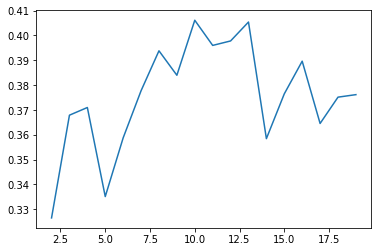

In [ ]:
x = np.arange(2, 20)
plt.plot(x,result)
plt.show()

The highest coherence score is achieved with 10 topics

In [11]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=diccionario,
                         num_topics=10, 
                         random_state=100,
                         chunksize=100,
                         passes=10)

In [ ]:
#temp_file = datapath("/content/drive/MyDrive/TFM/no_dups")
#lda_model.save(temp_file)

In [8]:
#temp_file = datapath("/content/drive/MyDrive/TFM/no_dups")
#lda_model = models.ldamodel.LdaModel.load(temp_file)

# Analysis with confidence intervals

In [12]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                choices = ['High', 'Medium', 'Low']
                conditions = [prop_topic>=0.66, (prop_topic<0.66) & (prop_topic>=0.33),
                              prop_topic<0.33]
                confidence = np.select(conditions,choices)
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords,confidence]),ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords','Confidence']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    labels = no_dups['Label']
    sent_topics_df = pd.concat([sent_topics_df, contents,labels], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=no_dups['Tokens'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords','Confidence', 'Text','Labels']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Confidence,Text,Labels
0,0,6.0,0.7792,"imag, generat, encod, style, model, decod, use...",High,"[gan, tts, gan, tts, gan, tts, generat, advers...",Sequential
1,1,5.0,0.5259,"model, train, languag, pre, task, modal, bert,...",Medium,"[bert, bert, bert, bidirect, encod, represent,...",Natural Language Processing
2,2,3.0,0.9775,"learn, use, model, train, distribut, predict, ...",High,"[fasttext, fasttext, fasttext, embed, exploit,...",Natural Language Processing
3,3,0.0,0.7309,"object, segment, mask, box, anchor, instanc, d...",High,"[faster, cnn, faster, cnn, faster, cnn, object...",Computer Vision
4,4,0.0,0.6465,"object, segment, mask, box, anchor, instanc, d...",Medium,"[rpn, region, propos, network, region, propos,...",Computer Vision
5,5,9.0,0.3279,"convolut, layer, block, use, network, channel,...",Low,"[convbert, convbert, convbert, modif, bert, ar...",Natural Language Processing
6,6,4.0,0.2733,"point, 3d, local, kernel, featur, convolut, ba...",Low,"[span, base, dynam, convolut, span, base, dyna...",Sequential
7,7,0.0,0.8506,"object, segment, mask, box, anchor, instanc, d...",High,"[mask, cnn, mask, cnn, mask, cnn, extend, fast...",Computer Vision
8,8,4.0,0.5669,"point, 3d, local, kernel, featur, convolut, ba...",Medium,"[roialign, roialign, region, interest, align, ...",Computer Vision
9,9,6.0,0.7997,"imag, generat, encod, style, model, decod, use...",High,"[vae, variat, autoencod, variat, autoencod, ty...",Computer Vision


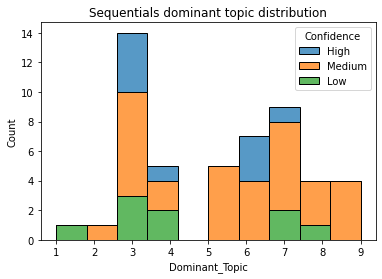

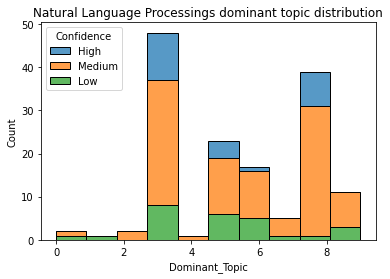

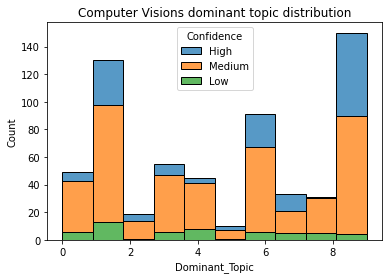

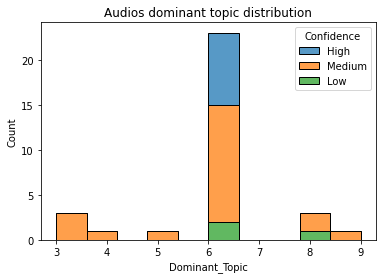

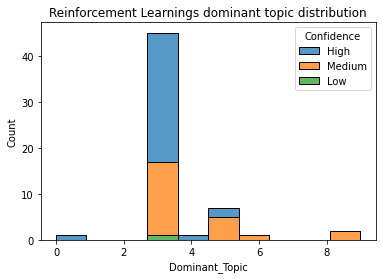

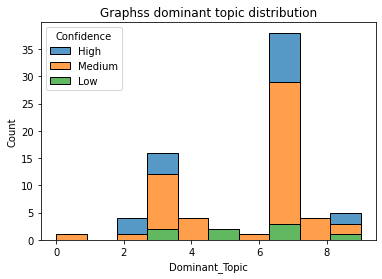

In [14]:
for i in range(len(df_dominant_topic)):
  df_dominant_topic.loc[i,'Confidence'] = str(df_dominant_topic.loc[i,'Confidence'])
labels = no_dups['Label'].unique()
for lab in labels:
  df = df_dominant_topic[df_dominant_topic['Labels']==lab]
  sns.histplot(data=df,x='Dominant_Topic', hue="Confidence",
               multiple='stack', bins=10, hue_order=['High', 'Medium','Low'])
  plt.title(f'{lab}s dominant topic distribution')
  plt.show()

Graphs - 7 \\
Reinforcement learning - 3 \\
Audios - 6 \\
Computer vision - 1,9,6 (la que más 0 tiene) \\
NLP - 3,8 (5 por descarte) \\
Sequential - 3 (menos 6,7,4) \\



# Analysis with first and second dominant topics

In [24]:
def format_topics_sentences_2(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        #i = 1 row_list = [(0, 0.27679166), (3, 0.27490905), (6, 0.3157097), (9, 0.102254316)]
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if len(row) == 1:
          top = row[0][0]
          prop_topic = round(row[0][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic>=0.66, (prop_topic<0.66) & (prop_topic>=0.33),
                        prop_topic<0.33]
          conf_1 = np.select(conditions,choices)
          sent_topics_df = sent_topics_df.append(pd.Series([top,prop_topic,conf_1,np.nan,np.nan,np.nan]),ignore_index=True)
        else:
          top_1 = row[0][0]
          prop_topic_1 = round(row[0][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic_1>=0.66, (prop_topic_1<0.66) & (prop_topic_1>=0.33),
                        prop_topic_1<0.33]
          conf_1 = np.select(conditions,choices)
          top_2 = row[1][0]
          prop_topic_2 = round(row[1][1],4)
          choices = ['High', 'Medium', 'Low']
          conditions = [prop_topic_2>=0.66, (prop_topic_2<0.66) & (prop_topic_2>=0.33),
                        prop_topic_2<0.33]
          conf_2 = np.select(conditions,choices)
          sent_topics_df = sent_topics_df.append(pd.Series([top_1,prop_topic_1,conf_1,top_2,prop_topic_2,conf_2]),ignore_index=True)
    # Add original text to the end of the output
    contents = pd.Series(texts)
    labels = no_dups['Label']
    sent_topics_df = pd.concat([sent_topics_df, contents,labels], axis=1)

    return(sent_topics_df)

df_topic_sents_keywords_2 = format_topics_sentences_2(ldamodel=lda_model, corpus=corpus, texts=no_dups['Tokens'])

In [25]:
# Format
df_dominant_topic_2 = df_topic_sents_keywords_2.reset_index()
df_dominant_topic_2.columns = ['Document_No', 'Dominant_Topic_1', 'Topic_1_Perc_Contrib',
                               'Confidence_1', 'Dominant_Topic_2', 'Topic_2_Perc_Contrib',
                               'Confidence_2','Text','Labels']
df_dominant_topic_2.head(10)

,Document_No,Dominant_Topic_1,Topic_1_Perc_Contrib,Confidence_1,Dominant_Topic_2,Topic_2_Perc_Contrib,Confidence_2,Text,Labels
0,0,6.0,0.7792,High,9.0,0.2127,Low,"[gan, tts, gan, tts, gan, tts, generat, advers...",Sequential
1,1,5.0,0.5259,Medium,3.0,0.4175,Medium,"[bert, bert, bert, bidirect, encod, represent,...",Natural Language Processing
2,2,3.0,0.9775,High,NaN,NaN,NaN,"[fasttext, fasttext, fasttext, embed, exploit,...",Natural Language Processing
3,3,0.0,0.7309,High,1.0,0.1287,Low,"[faster, cnn, faster, cnn, faster, cnn, object...",Computer Vision
4,4,0.0,0.6465,Medium,1.0,0.1880,Low,"[rpn, region, propos, network, region, propos,...",Computer Vision
5,5,9.0,0.3279,Low,8.0,0.2996,Low,"[convbert, convbert, convbert, modif, bert, ar...",Natural Language Processing
6,6,4.0,0.2733,Low,8.0,0.2265,Low,"[span, base, dynam, convolut, span, base, dyna...",Sequential
7,7,0.0,0.8506,High,1.0,0.0631,Low,"[mask, cnn, mask, cnn, mask, cnn, extend, fast...",Computer Vision
8,8,4.0,0.5669,Medium,0.0,0.1817,Low,"[roialign, roialign, region, interest, align, ...",Computer Vision
9,9,6.0,0.7997,High,3.0,0.1781,Low,"[vae, variat, autoencod, variat, autoencod, ty...",Computer Vision


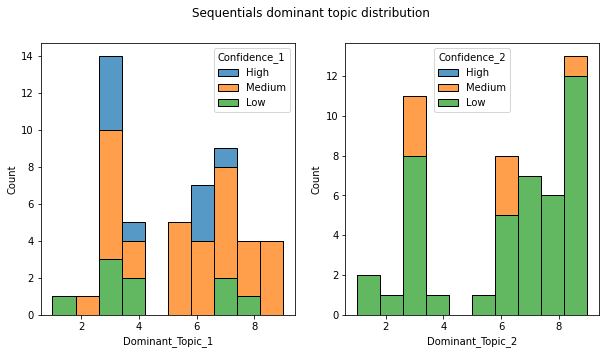

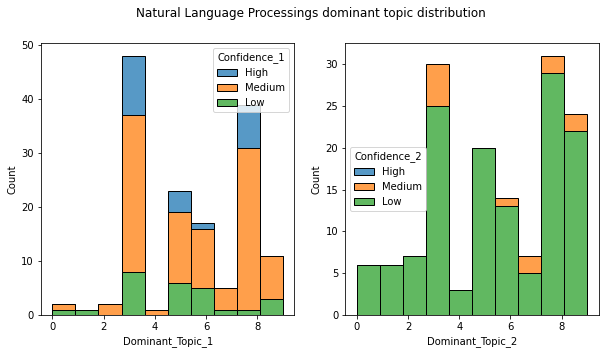

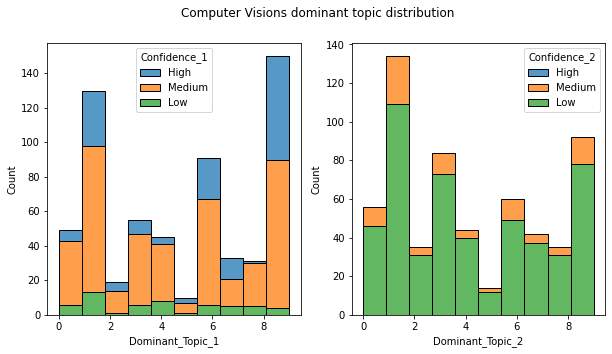

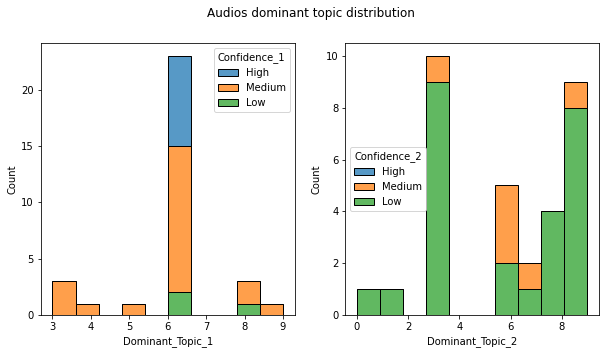

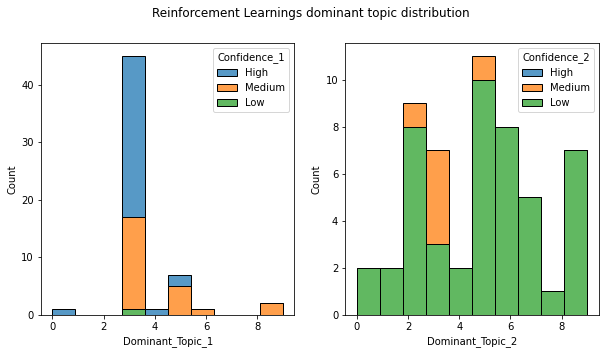

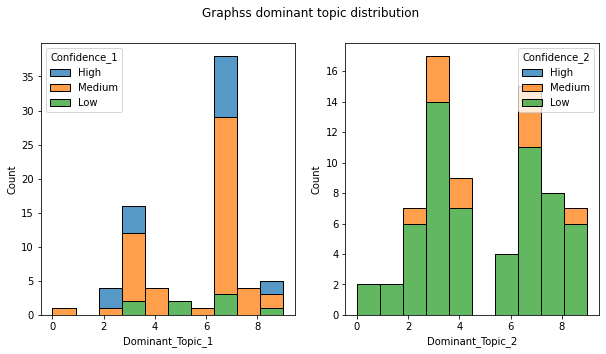

In [34]:
for i in range(len(df_dominant_topic_2)):
  df_dominant_topic_2.loc[i,'Confidence_1'] = str(df_dominant_topic_2.loc[i,'Confidence_1'])
  df_dominant_topic_2.loc[i,'Confidence_2'] = str(df_dominant_topic_2.loc[i,'Confidence_2'])
labels = no_dups['Label'].unique()
for lab in labels:
  df = df_dominant_topic_2[df_dominant_topic_2['Labels']==lab]
  fig = plt.figure(figsize=(10,5))
  fig.suptitle(f'{lab}s dominant topic distribution')
  gs = gridspec.GridSpec(nrows=1, 
                       ncols=2)
  ax1 = fig.add_subplot(gs[0, 0])
  sns.histplot(data=df,x='Dominant_Topic_1', hue="Confidence_1", 
               multiple="stack", bins=10, hue_order=['High', 'Medium', 'Low'])
  ax2 = fig.add_subplot(gs[0, 1])
  sns.histplot(data=df,x='Dominant_Topic_2', hue="Confidence_2", 
               multiple="stack", bins=10, hue_order=['High', 'Medium', 'Low'])
  plt.show()